# Multivariate Time-Series Forecasting: Predict Iron Prices

### Import libs

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam



In [124]:
def pipeline(filepath_str):
    # import training dataset
    filepath= r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated'+f'\{filepath_str}'
    dataset_train= pd.read_excel(filepath)
    element_name= dataset_train.pop('element_name')[0]
    dataset_train.columns = ['date','price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
    dataset_train= dataset_train.sort_values(by=['date'], ascending=True)

    # features selection
    cols= list(dataset_train)[1:-1]

    # Extract dates (timestamp format)
    datelist_train = list(dataset_train['date'])
    
    # dataset_train.index= dataset_train.pop('date')
    print(dataset_train)
    print('Training set shape == {}'.format(dataset_train.shape))
    print('All timestamps == {}'.format(len(datelist_train)))
    print('Featured selected: {}'.format(cols))
    print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))
    


    # dataset traing will be the essanse of all the upcoming datasets(training_set, training_set_scaled, X_train, y_train...)
    # make sure there are no commas in any number                                                      "Target"      |--------------------"Predictors"-------------------|
    dataset_train = dataset_train[cols].astype(str) # to remove the date and select only the features : ['price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
    for i in cols:
        for j in range(0, len(dataset_train)):
            dataset_train[i][j] = dataset_train[i][j].replace(',', '')

    dataset_train = dataset_train.astype(float)

    # by using multiple predictors (features) we need to convert (reshape) to a matrix(array) using .to_numpy
    training_set= dataset_train.to_numpy()

    # Feature scaling hence features vary in range
    sc = StandardScaler()
    training_set_scaled = sc.fit_transform(training_set)

    sc_predict = StandardScaler()
    target_scaled= sc_predict.fit_transform(training_set[:, 0:1])

    print('Shape of training set        == {}.'.format(training_set.shape))
    print('Shape of training set scaled == {}.'.format(training_set_scaled.shape))

    # Create a data structure with timestamps
    # Target/features selection
    X_train= []
    y_train= []
    n_future= 6 # number of moths to be predicted
    n_past= 12 # the size of the windowed dataframe

    for i in range(n_past, len(training_set_scaled) - n_future +1):
        X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
        y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print('X_train shape == {}.'.format(X_train.shape))
    print('y_train shape == {}.'.format(y_train.shape))



    # Generate list of sequence of months for predictions w datetime type
    datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
    datelist_future_= []
    for d in datelist_future:
        d= d + dt.timedelta(days=1)
        d= d.date()
        datelist_future_.append(d)
    datelist_future= datelist_future_
    del datelist_future_

    datelist_train_= []
    for this_timestamp in datelist_train:
        datelist_train_.append(this_timestamp.date())
    datelist_train= datelist_train_
    del datelist_train_



    # build the model
    model= Sequential()
    model.add(LSTM(units=16, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
    model.add(Dropout(.20))
    model.add(LSTM(units=10, return_sequences=False))
    model.add(Dropout(.30))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer= Adam(learning_rate=.0075), loss= 'mean_squared_error')
    # %%time
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')
    history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)



    # Perform predictions
    predictions_train = model.predict(X_train[n_past:])
    predictions_future = model.predict(X_train[-n_future:])

    y_pred_future = sc_predict.inverse_transform(predictions_future)
    y_pred_train = sc_predict.inverse_transform(predictions_train)

    # Prediction n_future
    # allocate original data point and predicted data point
    data_point_og, data_point_predicted= sc_predict.inverse_transform(target_scaled[-n_future:]), y_pred_future
    # calculate the factor
    factor= (data_point_og[-1] - data_point_predicted[-1]) / data_point_predicted[-1]

    data_point_predicted_w_factor= (data_point_predicted * factor) + data_point_predicted
    # data_point_predicted_w_factor= data_point_predicted

    # Prediction
    arr= np.array(data_point_predicted_w_factor)
    for i in range(n_future):
        m= arr.mean()
        arr= np.append(arr, m)
        arr= np.delete(arr, 0)
    data_point_predicted_w_factor= arr



    # Visualization
    training_start= 2 * n_past + n_future -1
    PREDICTIONS_FUTURE = pd.DataFrame(data_point_predicted_w_factor, columns=['predicted_forecast']).set_index(pd.Series(datelist_future))
    PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted_training']).set_index(pd.Series(datelist_train[training_start:]))

    dataset_train.index= datelist_train
    # Set plot size 
    from pylab import rcParams
    rcParams['figure.figsize'] = 14, 5

    # Plot parameters
    START_DATE_FOR_PLOTTING = '2013-01-01'

    plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['predicted_forecast'], color='r', label=f'{element_name}')
    plt.plot(PREDICTION_TRAIN.loc[:].index, PREDICTION_TRAIN.loc[:]['predicted_training'], color='r', label='Training predictions')
    plt.plot(dataset_train.loc[:].index, dataset_train.loc[:]['price'], color='b', label=f'Actual "{element_name}" Price')

    plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

    plt.grid(which='major', color='#cccccc', alpha=0.5)

    plt.legend(shadow=True)
    plt.title(f'Predcitions and Acutal: {element_name}', family='Arial', fontsize=12)
    plt.xlabel('Timeline', family='Arial', fontsize=10)
    plt.ylabel('Value', family='Arial', fontsize=10)
    plt.xticks(rotation=45, fontsize=8)
    plt.show()



    
    # final result to export
    df_price= pd.DataFrame(dataset_train.loc[:]['price'])
    df_price
    df_final_res = pd.merge(df_price, PREDICTION_TRAIN, how='left', left_index=True, right_index=True)
    df_final_res
    df_final_res= df_final_res.append(PREDICTIONS_FUTURE)
    df_final_res['element_name']= element_name
    return df_final_res

In [125]:
elements= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated\type names.xlsx')
elements.columns= ['element_name']

          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  48.041     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  47.394     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  47.755     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  46.900     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  46.690     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  73.140     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  72.180     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  72.410     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  68.700      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  65.100      85.14  11,405.32  1,672.00           2.56   

     historical  
0     46.025276  
1     48.041000  
2     47.394000  
3     47.755000  
4     46.900000  
..          ...

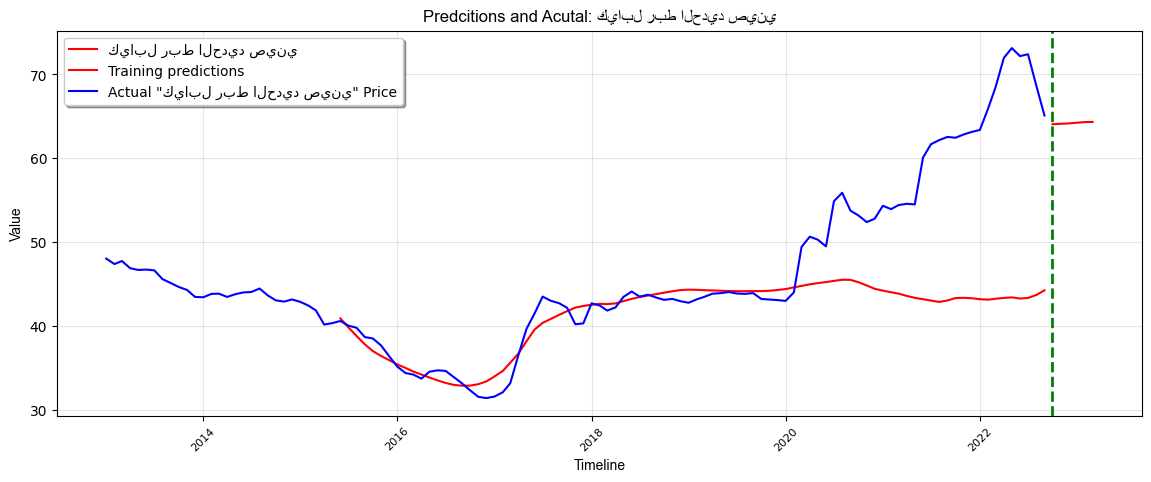

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date  price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2.045     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2.039     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2.050     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2.021     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2.018     100.20   7,404.12  1,393.00           0.11   
..         ...    ...        ...        ...       ...            ...   
112 2022-05-01  2.600     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  2.610     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  2.610     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  2.560      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  2.530      85.14  11,405.32  1,672.00           2.56   

     historical  
0      1.865328  
1      2.045000  
2      2.039000  
3      2.050000  
4      2.021000  
..          ...  
112    2.

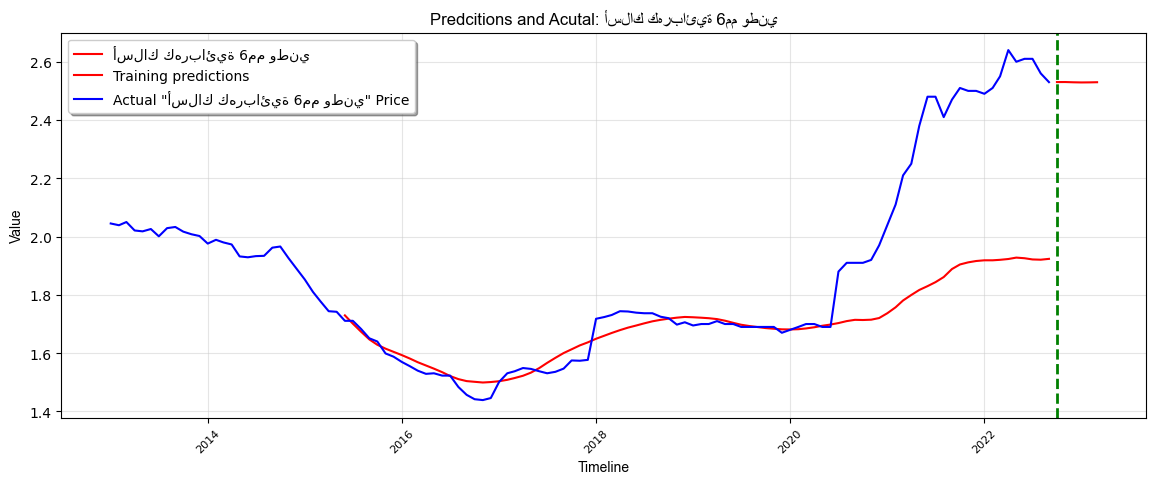

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  40.191     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  39.886     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  40.096     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  40.100     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  40.079     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  39.110     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  39.460     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  39.200     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  39.170      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  38.960      85.14  11,405.32  1,672.00           2.56   

     historical  
0     39.951181  
1     40.191000  
2     39.886000  
3     40.096000  
4     40.100000  
..          ...

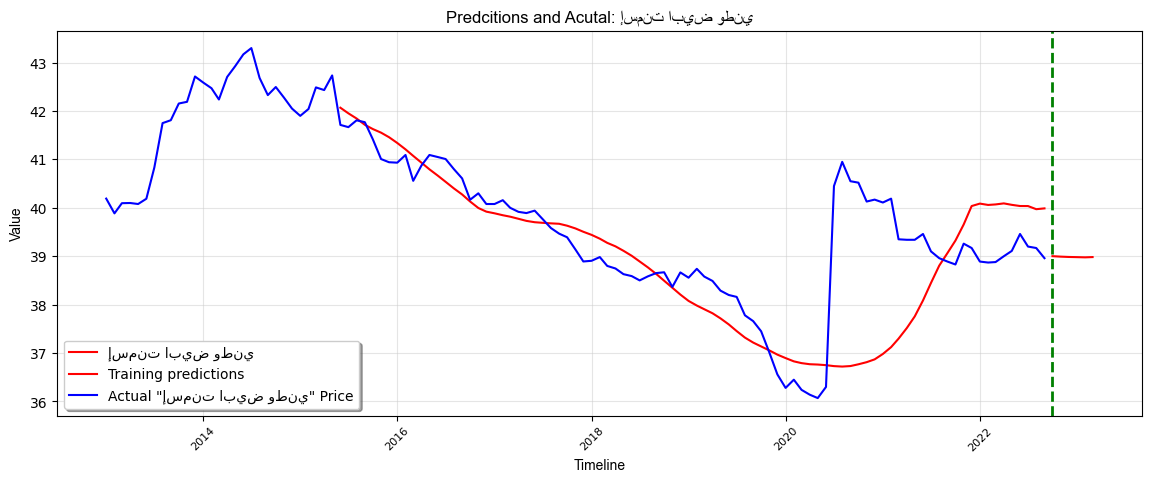

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date    price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01   88.567     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01   88.624     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01   88.809     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01   88.806     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01   88.321     100.20   7,404.12  1,393.00           0.11   
..         ...      ...        ...        ...       ...            ...   
112 2022-05-01  120.320     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  119.870     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  119.130     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  118.000      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  116.510      85.14  11,405.32  1,672.00           2.56   

     historical  
0     81.446336  
1     88.567000  
2     88.624000  
3     88.809000  
4     88.806000  
.. 

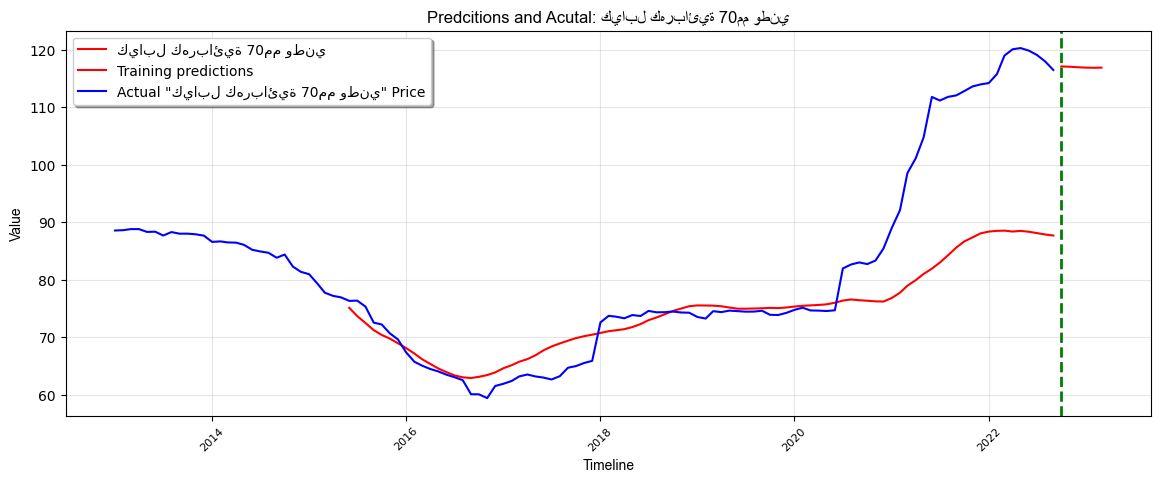

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date    price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  220.355     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  219.226     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  220.161     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  219.762     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  221.131     100.20   7,404.12  1,393.00           0.11   
..         ...      ...        ...        ...       ...            ...   
111 2022-05-01  223.890     115.60  12,921.74  1,848.40           0.77   
112 2022-06-01  224.240     109.03  11,523.25  1,812.00           1.21   
113 2022-07-01  223.610     103.97  12,199.08  1,771.50           1.68   
114 2022-08-01  222.230      95.64  12,283.33  1,721.40           2.33   
115 2022-09-01  222.700      85.14  11,405.32  1,672.00           2.56   

     historical  
0    208.797478  
1    220.355000  
2    219.226000  
3    220.161000  
4    219.762000  
.. 

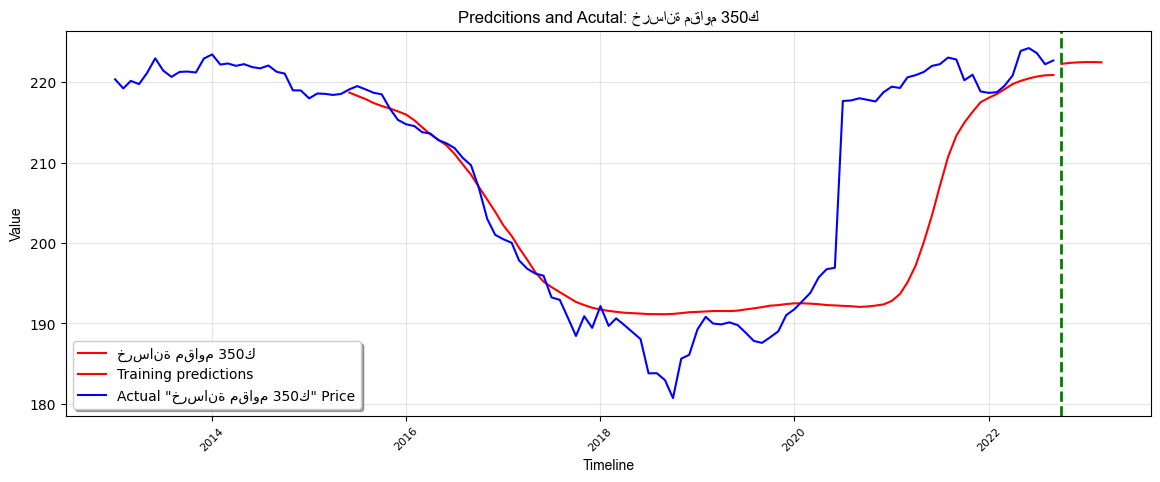

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  20.714     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  20.864     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  20.794     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  20.860     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  20.904     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  23.130     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  23.230     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  23.310     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  23.360      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  23.210      85.14  11,405.32  1,672.00           2.56   

     historical  
0     21.634353  
1     20.714000  
2     20.864000  
3     20.794000  
4     20.860000  
..          ...

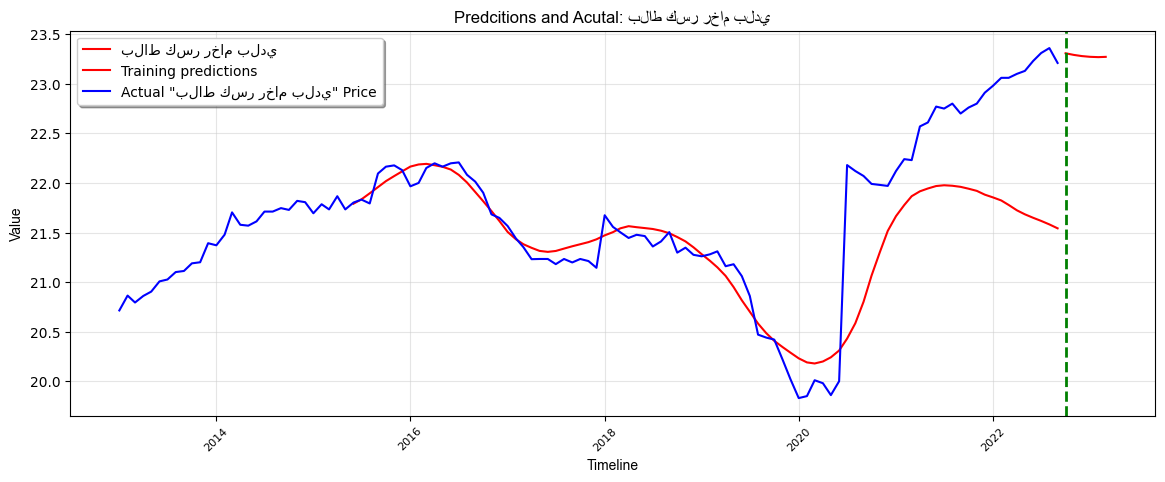

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2944.500     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2944.958     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2944.750     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2944.667     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2944.583     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  3991.880     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  3699.080     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3591.240     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3284.480      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3115.660      85.14  11,405.32  1,672.00           2.56   

      historical  
0    2607.920284  
1    2944.500000  
2    2944.958000  
3    2944.750000  
4   

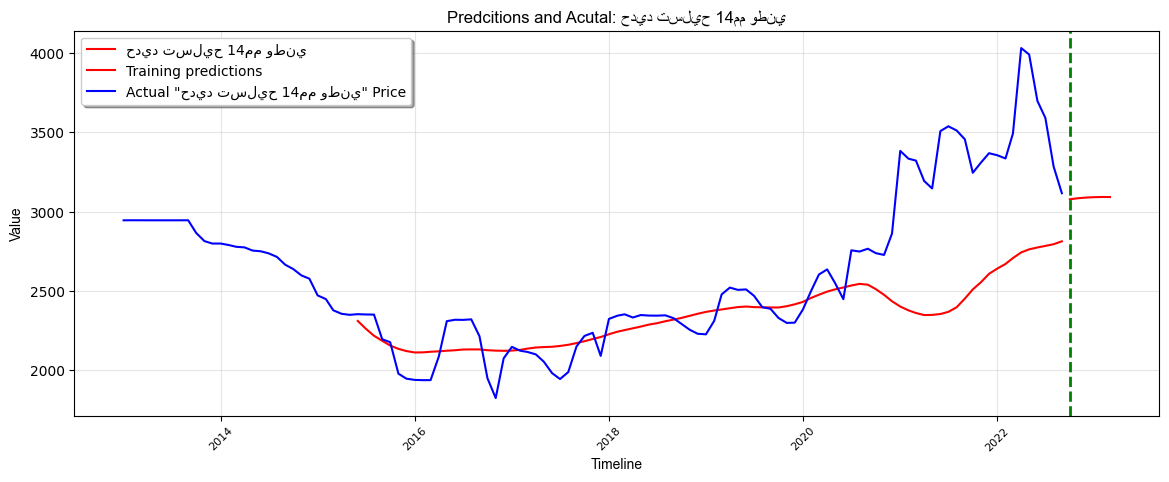

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date    price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  151.690     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  152.417     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  151.056     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  151.717     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  150.472     100.20   7,404.12  1,393.00           0.11   
..         ...      ...        ...        ...       ...            ...   
112 2022-05-01  209.590     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  207.270     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  205.990     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  205.140      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  201.660      85.14  11,405.32  1,672.00           2.56   

     historical  
0    140.942103  
1    151.690000  
2    152.417000  
3    151.056000  
4    151.717000  
.. 

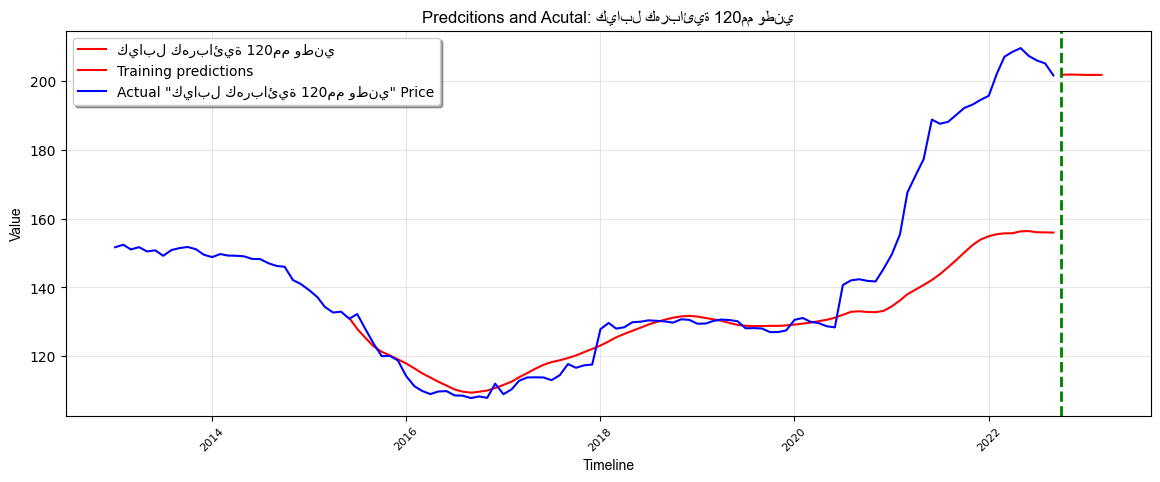

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  1125.078     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  1120.586     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  1117.539     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  1123.400     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  1124.153     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
113 2022-05-01  1892.130     115.60  12,921.74  1,848.40           0.77   
114 2022-06-01  1867.310     109.03  11,523.25  1,812.00           1.21   
115 2022-07-01  1770.240     103.97  12,199.08  1,771.50           1.68   
116 2022-08-01  1688.260      95.64  12,283.33  1,721.40           2.33   
117 2022-09-01  1674.200      85.14  11,405.32  1,672.00           2.56   

     historical  
0    1151.78194  
1    1125.07800  
2    1120.58600  
3    1117.53900  
4    1123

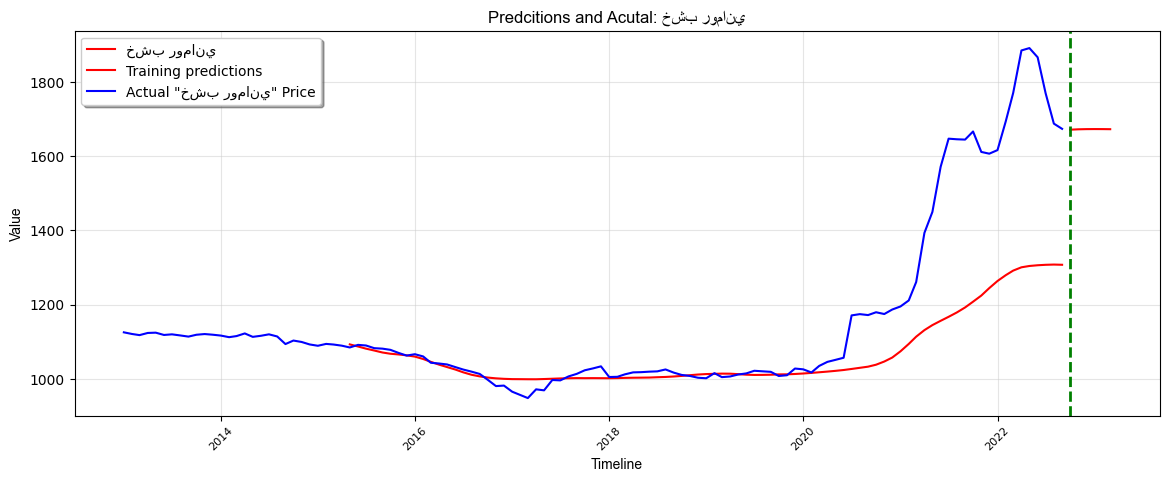

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date    price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  199.210     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  198.081     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  198.702     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  199.320     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  199.156     100.20   7,404.12  1,393.00           0.11   
..         ...      ...        ...        ...       ...            ...   
111 2022-05-01  200.840     115.60  12,921.74  1,848.40           0.77   
112 2022-06-01  201.200     109.03  11,523.25  1,812.00           1.21   
113 2022-07-01  201.690     103.97  12,199.08  1,771.50           1.68   
114 2022-08-01  200.520      95.64  12,283.33  1,721.40           2.33   
115 2022-09-01  200.650      85.14  11,405.32  1,672.00           2.56   

     historical  
0     188.79773  
1     199.21000  
2     198.08100  
3     198.70200  
4     199.32000  
.. 

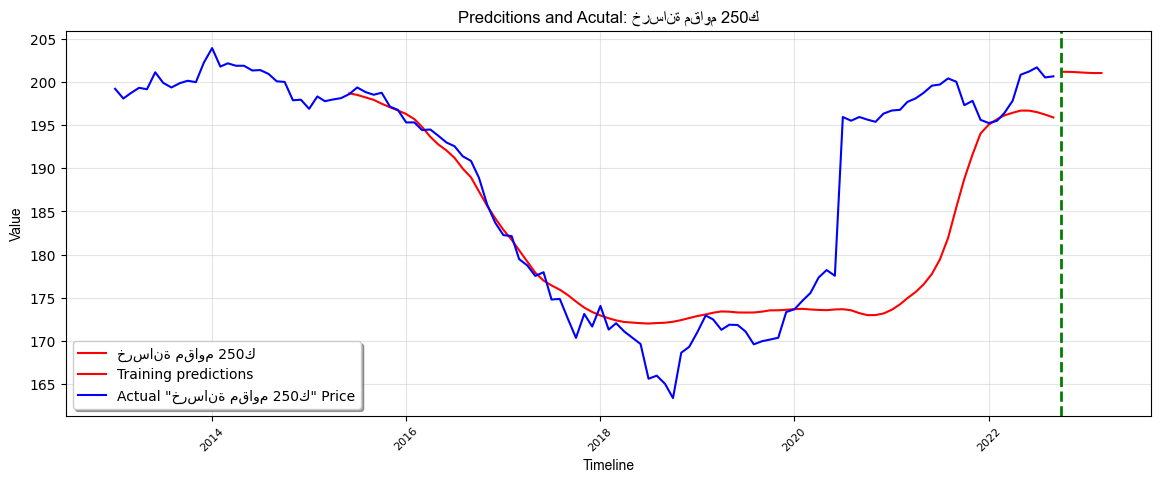

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  27.363     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  27.155     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  27.581     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  27.894     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  27.063     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  27.600     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  27.610     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  27.650     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  27.730      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  27.680      85.14  11,405.32  1,672.00           2.56   

     historical  
0     25.477664  
1     27.363000  
2     27.155000  
3     27.581000  
4     27.894000  
..          ...

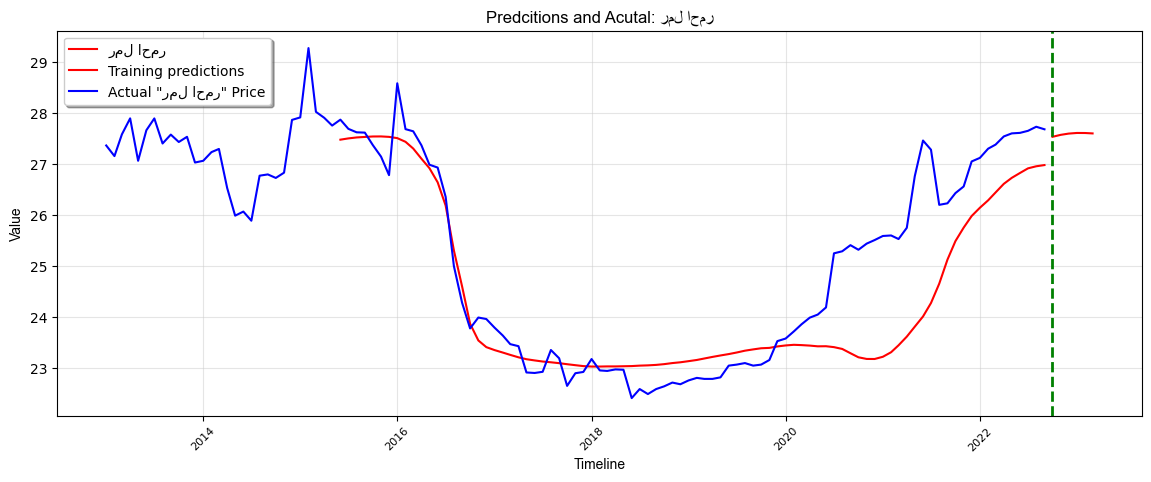

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date  price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  0.913     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  0.911     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  0.912     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  0.908     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  0.898     100.20   7,404.12  1,393.00           0.11   
..         ...    ...        ...        ...       ...            ...   
112 2022-05-01  1.180     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1.180     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1.180     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1.160      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1.110      85.14  11,405.32  1,672.00           2.56   

     historical  
0      0.819371  
1      0.913000  
2      0.911000  
3      0.912000  
4      0.908000  
..          ...  
112    1.

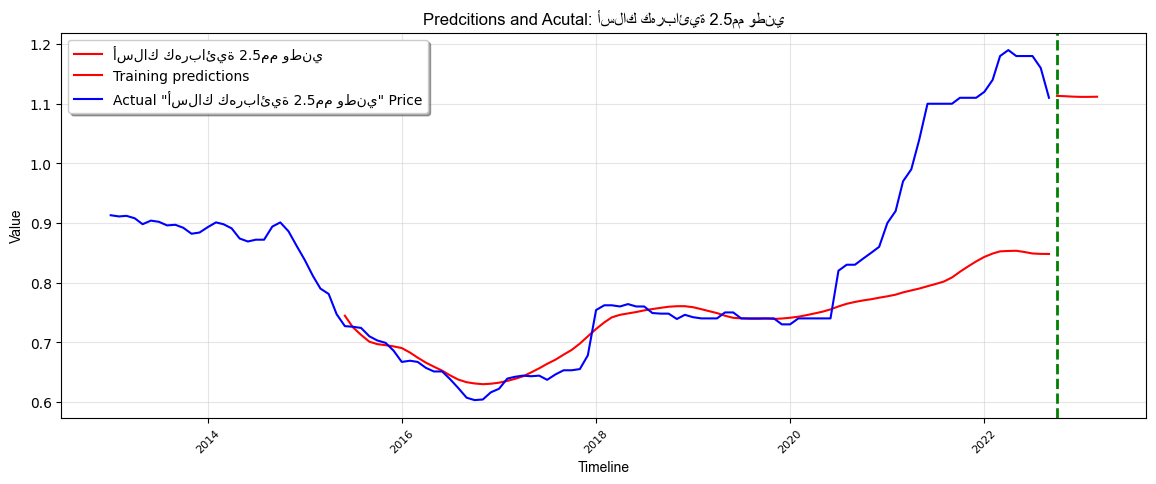

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  59.889     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  60.244     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  60.602     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  60.500     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  60.182     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  84.470     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  84.250     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  83.730     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  83.200      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  82.310      85.14  11,405.32  1,672.00           2.56   

     historical  
0     56.419379  
1     59.889000  
2     60.244000  
3     60.602000  
4     60.500000  
..          ...

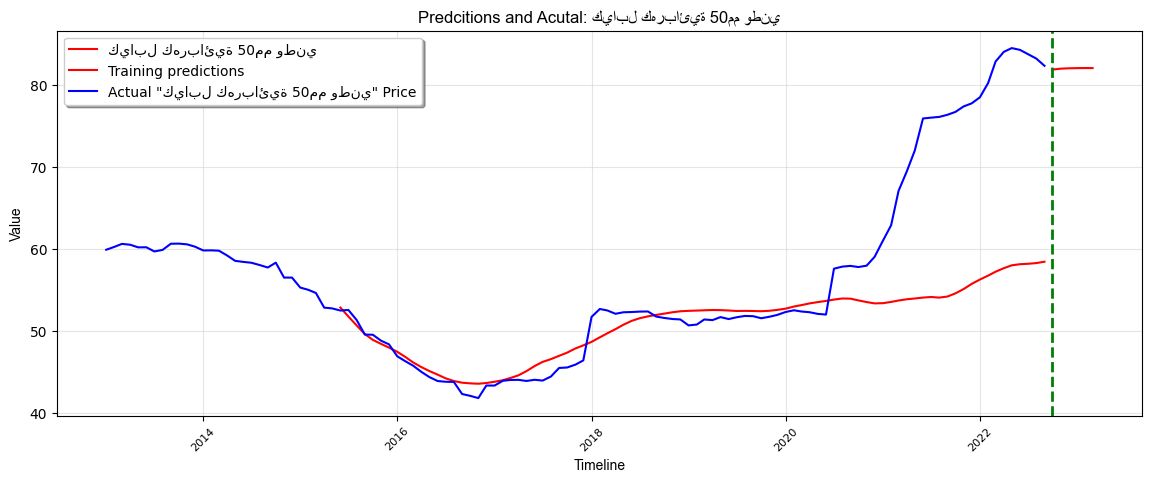

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  15.181     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  15.335     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  16.053     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  15.955     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  16.057     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  14.470     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  14.850     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  14.790     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  14.640      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  14.330      85.14  11,405.32  1,672.00           2.56   

     historical  
0     14.089526  
1     15.181000  
2     15.335000  
3     16.053000  
4     15.955000  
..          ...

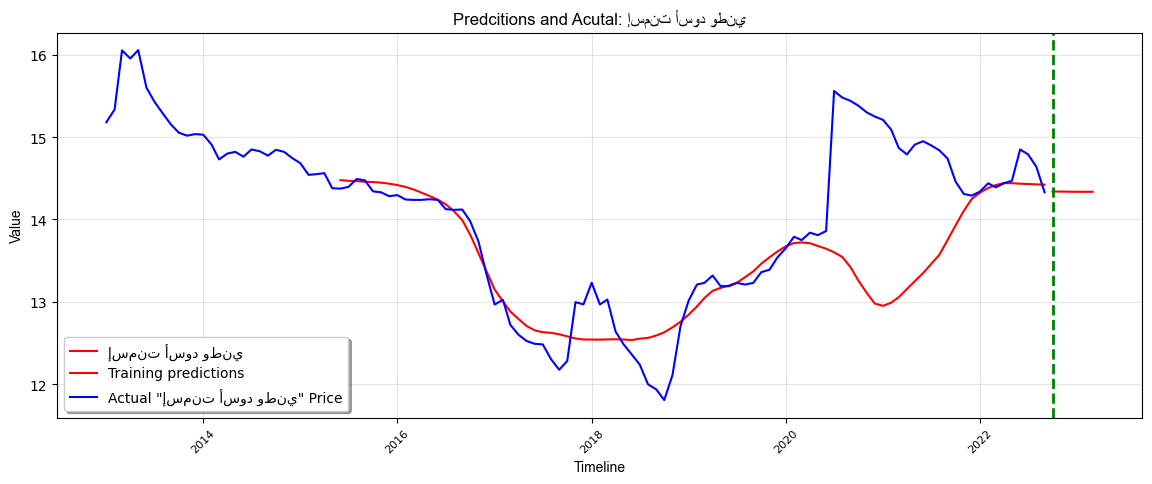

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2426.784     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2423.246     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2425.873     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2426.246     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2423.881     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
113 2022-05-01  3526.990     115.60  12,921.74  1,848.40           0.77   
114 2022-06-01  3471.080     109.03  11,523.25  1,812.00           1.21   
115 2022-07-01  3394.420     103.97  12,199.08  1,771.50           1.68   
116 2022-08-01  3382.560      95.64  12,283.33  1,721.40           2.33   
117 2022-09-01  3388.990      85.14  11,405.32  1,672.00           2.56   

      historical  
0    2502.122009  
1    2426.784000  
2    2423.246000  
3    2425.873000  
4   

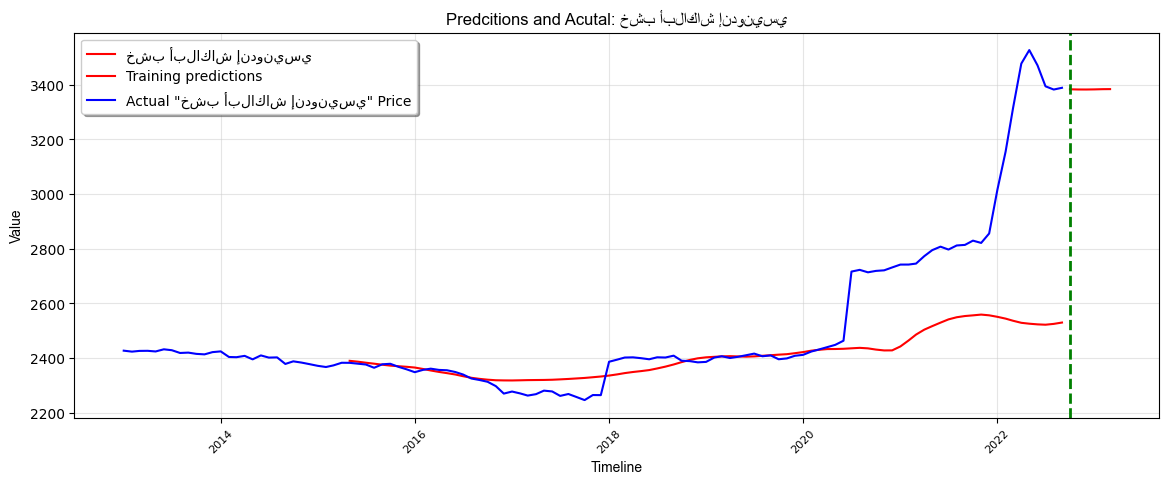

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  3887.931     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  3888.793     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  3883.621     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  3856.780     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  3894.828     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
113 2022-05-01  5677.260     115.60  12,921.74  1,848.40           0.77   
114 2022-06-01  5712.010     109.03  11,523.25  1,812.00           1.21   
115 2022-07-01  5764.730     103.97  12,199.08  1,771.50           1.68   
116 2022-08-01  5785.020      95.64  12,283.33  1,721.40           2.33   
117 2022-09-01  5723.280      85.14  11,405.32  1,672.00           2.56   

      historical  
0    4564.637393  
1    3887.931000  
2    3888.793000  
3    3883.621000  
4   

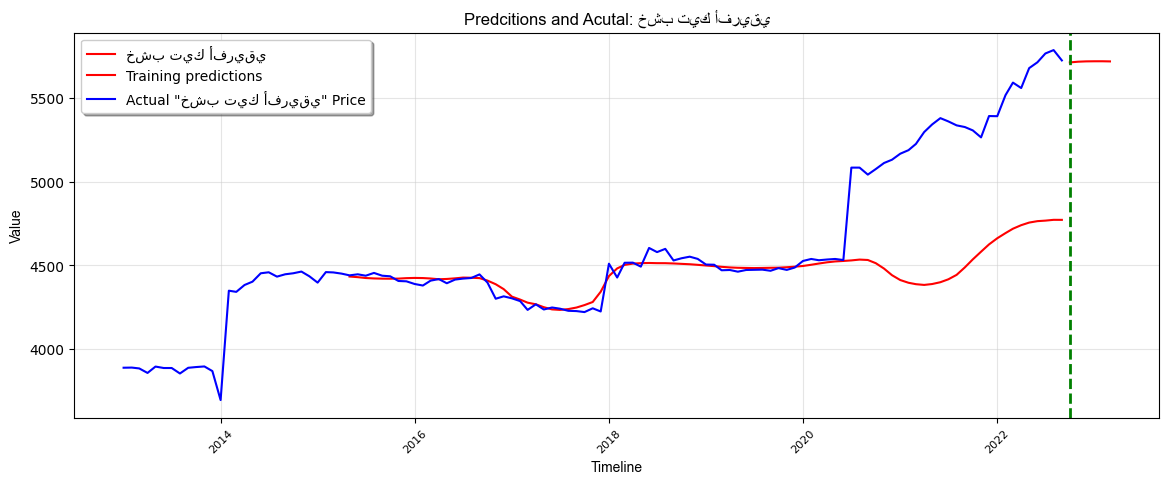

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  34.545     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  34.511     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  34.603     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  34.502     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  34.081     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  46.470     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  46.080     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  45.800     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  45.270      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  44.870      85.14  11,405.32  1,672.00           2.56   

     historical  
0     31.562181  
1     34.545000  
2     34.511000  
3     34.603000  
4     34.502000  
..          ...

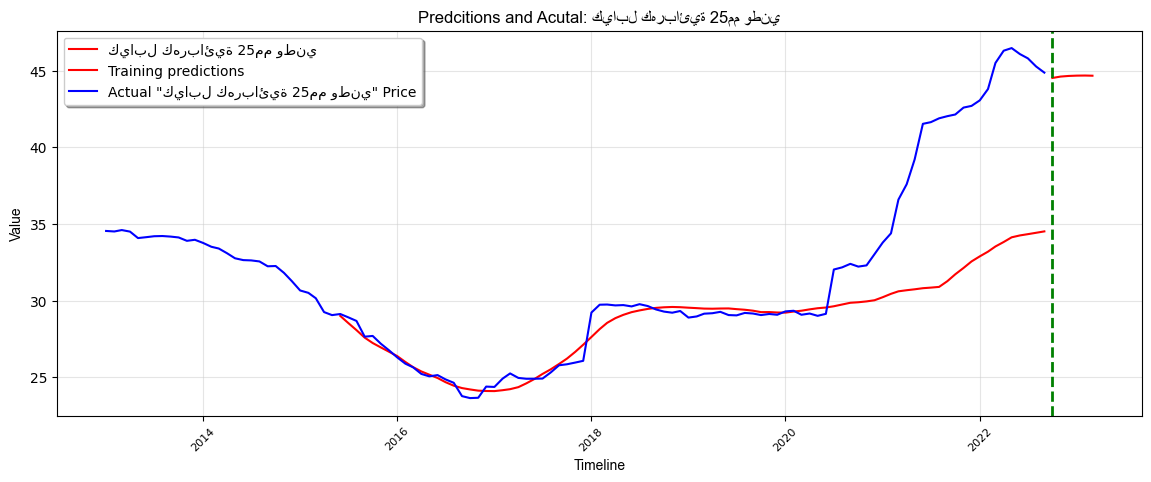

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2935.086     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2935.086     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2935.086     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2935.086     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2935.086     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  3992.870     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  3691.880     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3575.930     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3281.390      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3107.700      85.14  11,405.32  1,672.00           2.56   

      historical  
0    2601.718069  
1    2935.086000  
2    2935.086000  
3    2935.086000  
4   

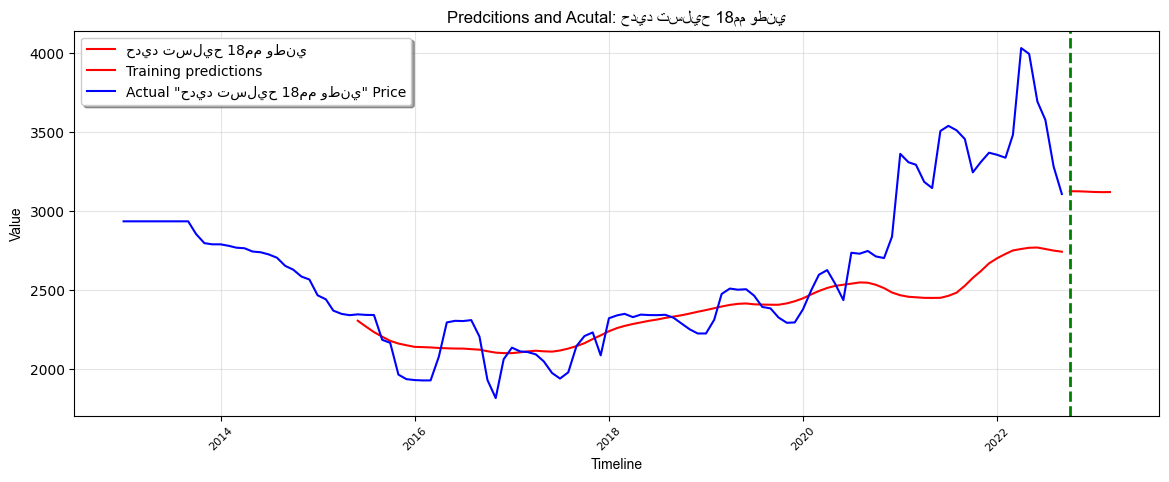

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  1670.354     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  1668.103     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  1685.345     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  1693.534     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  1697.845     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  1761.660     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1763.190     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1766.020     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1766.480      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1757.290      85.14  11,405.32  1,672.00           2.56   

      historical  
0    1580.877043  
1    1670.354000  
2    1668.103000  
3    1685.345000  
4   

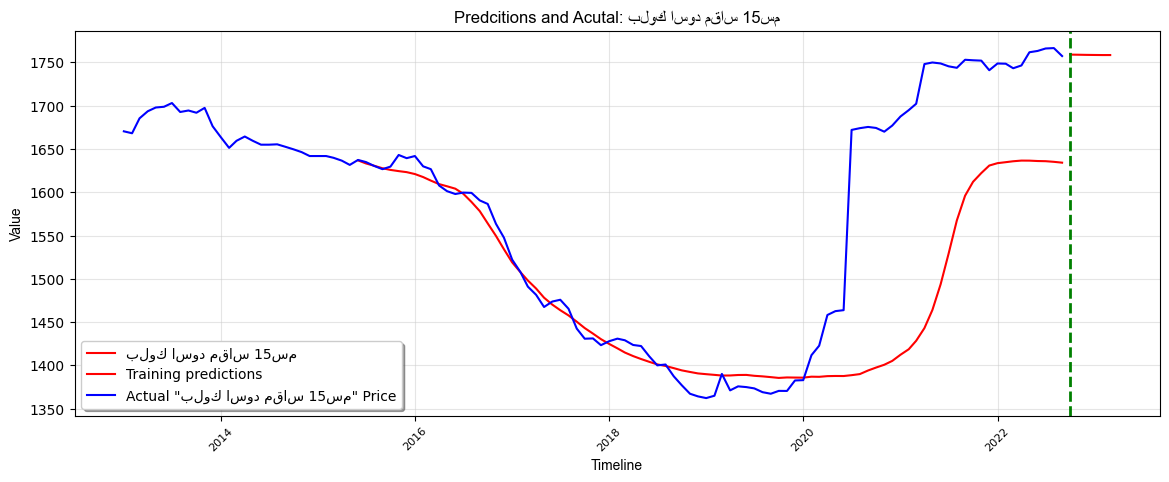

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  62.318     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  62.415     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  62.755     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  63.308     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  63.903     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  61.120     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  61.210     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  60.750     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  60.390      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  59.700      85.14  11,405.32  1,672.00           2.56   

     historical  
0     57.022983  
1     62.318000  
2     62.415000  
3     62.755000  
4     63.308000  
..          ...

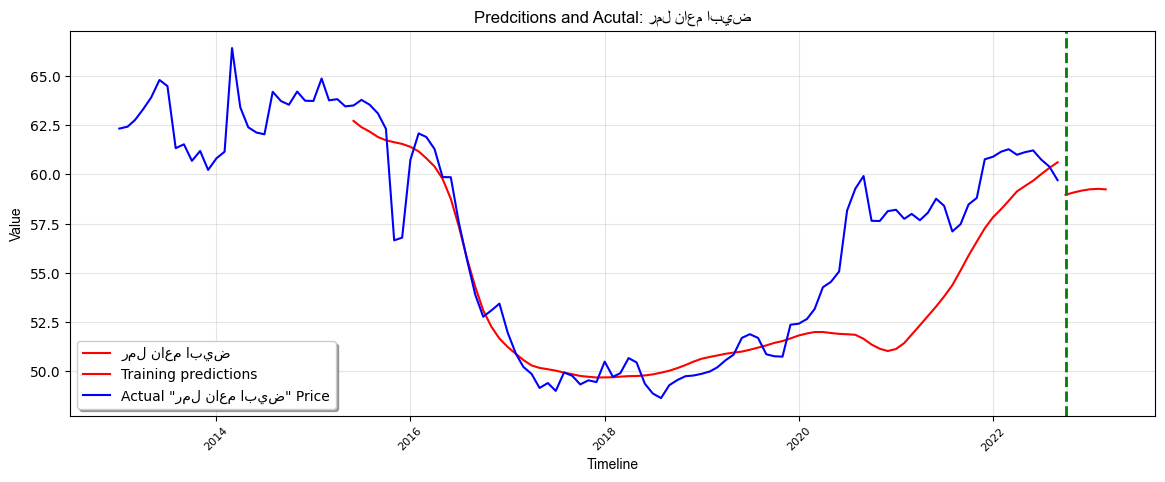

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date    price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  119.495     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  120.657     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  120.307     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  120.322     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  119.493     100.20   7,404.12  1,393.00           0.11   
..         ...      ...        ...        ...       ...            ...   
112 2022-05-01  164.360     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  162.790     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  162.050     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  161.190      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  158.210      85.14  11,405.32  1,672.00           2.56   

     historical  
0    111.259112  
1    119.495000  
2    120.657000  
3    120.307000  
4    120.322000  
.. 

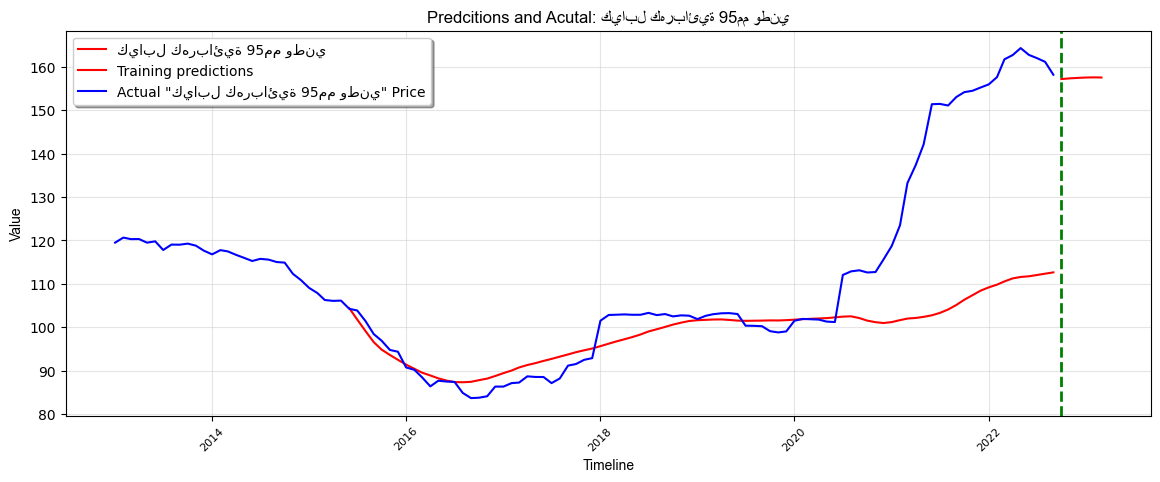

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date    price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  371.773     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  373.985     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  374.088     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  374.256     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  372.088     100.20   7,404.12  1,393.00           0.11   
..         ...      ...        ...        ...       ...            ...   
112 2022-05-01  523.330     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  520.060     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  515.010     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  511.960      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  509.730      85.14  11,405.32  1,672.00           2.56   

     historical  
0    346.119147  
1    371.773000  
2    373.985000  
3    374.088000  
4    374.256000  
.. 

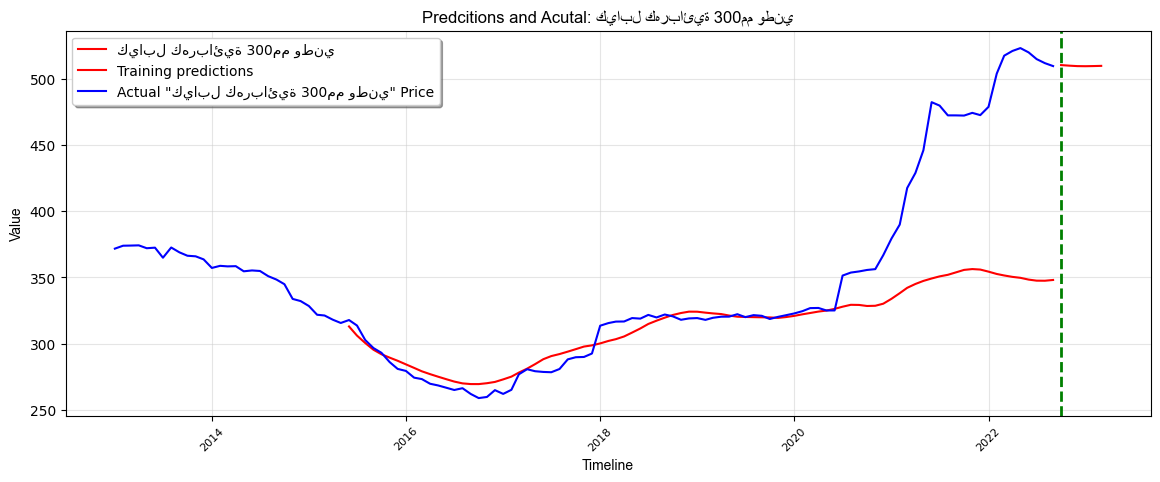

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date  price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  1.384     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  1.364     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  1.378     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  1.369     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  1.369     100.20   7,404.12  1,393.00           0.11   
..         ...    ...        ...        ...       ...            ...   
112 2022-05-01  1.730     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1.740     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1.730     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1.700      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1.650      85.14  11,405.32  1,672.00           2.56   

     historical  
0      1.235138  
1      1.384000  
2      1.364000  
3      1.378000  
4      1.369000  
..          ...  
112    1.

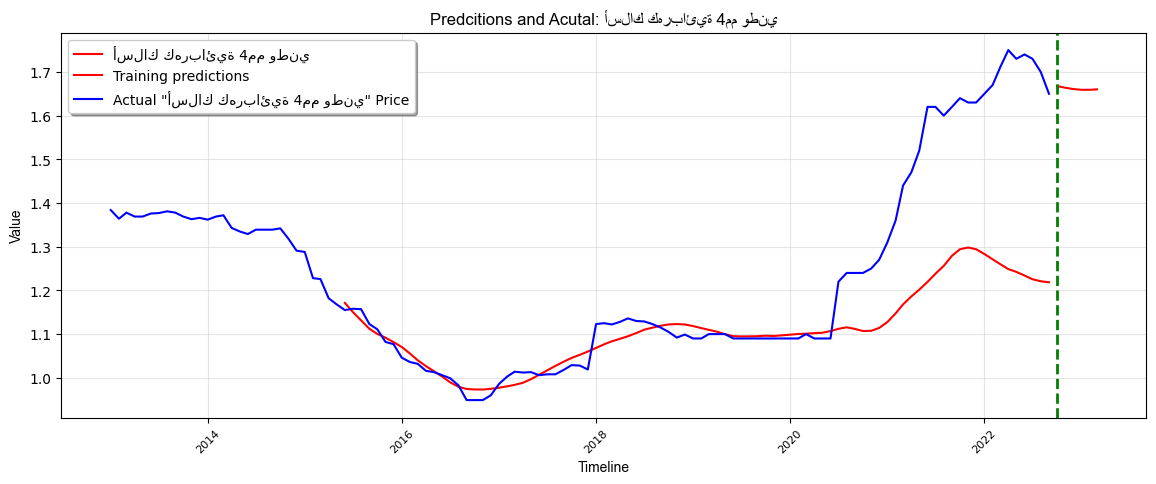

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  1768.534     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  1775.000     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  1784.583     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  1797.500     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  1800.417     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  1855.250     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1855.250     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1857.910     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1857.500      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1833.140      85.14  11,405.32  1,672.00           2.56   

      historical  
0    1664.218621  
1    1768.534000  
2    1775.000000  
3    1784.583000  
4   

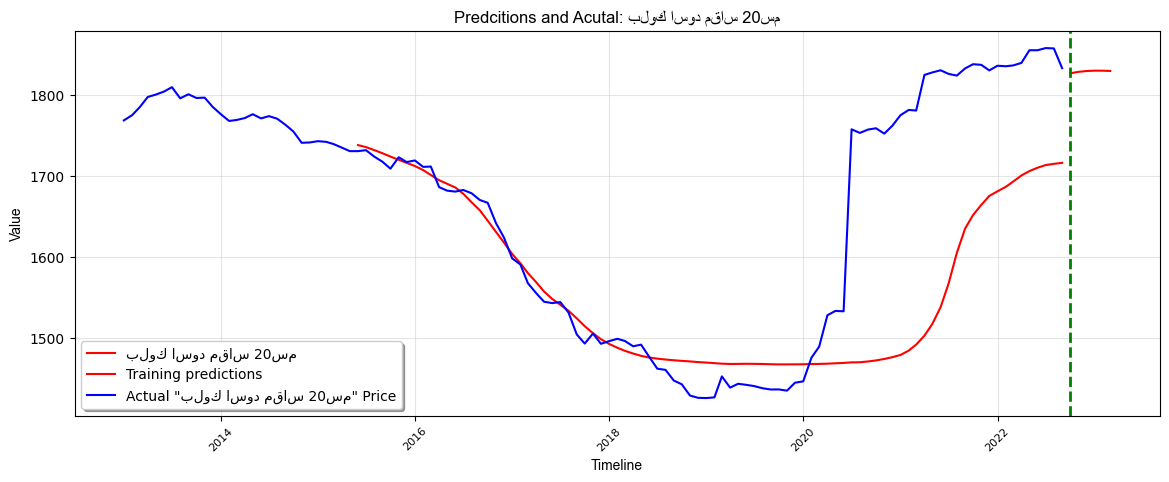

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date    price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  209.025     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  207.959     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  209.270     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  207.967     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  209.383     100.20   7,404.12  1,393.00           0.11   
..         ...      ...        ...        ...       ...            ...   
111 2022-05-01  214.730     115.60  12,921.74  1,848.40           0.77   
112 2022-06-01  215.140     109.03  11,523.25  1,812.00           1.21   
113 2022-07-01  214.490     103.97  12,199.08  1,771.50           1.68   
114 2022-08-01  212.960      95.64  12,283.33  1,721.40           2.33   
115 2022-09-01  213.050      85.14  11,405.32  1,672.00           2.56   

     historical  
0    199.081417  
1    209.025000  
2    207.959000  
3    209.270000  
4    207.967000  
.. 

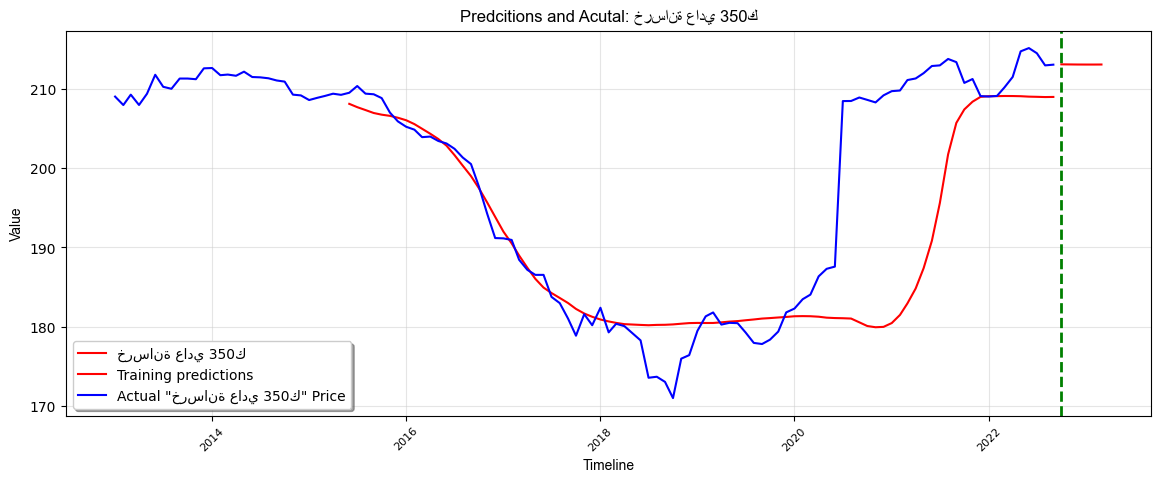

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  1098.810     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  1100.476     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  1103.333     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  1109.286     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  1106.591     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
113 2022-05-01  1989.600     115.60  12,921.74  1,848.40           0.77   
114 2022-06-01  1953.270     109.03  11,523.25  1,812.00           1.21   
115 2022-07-01  1861.250     103.97  12,199.08  1,771.50           1.68   
116 2022-08-01  1799.330      95.64  12,283.33  1,721.40           2.33   
117 2022-09-01  1766.150      85.14  11,405.32  1,672.00           2.56   

     historical  
0      1173.239  
1      1098.810  
2      1100.476  
3      1103.333  
4      11

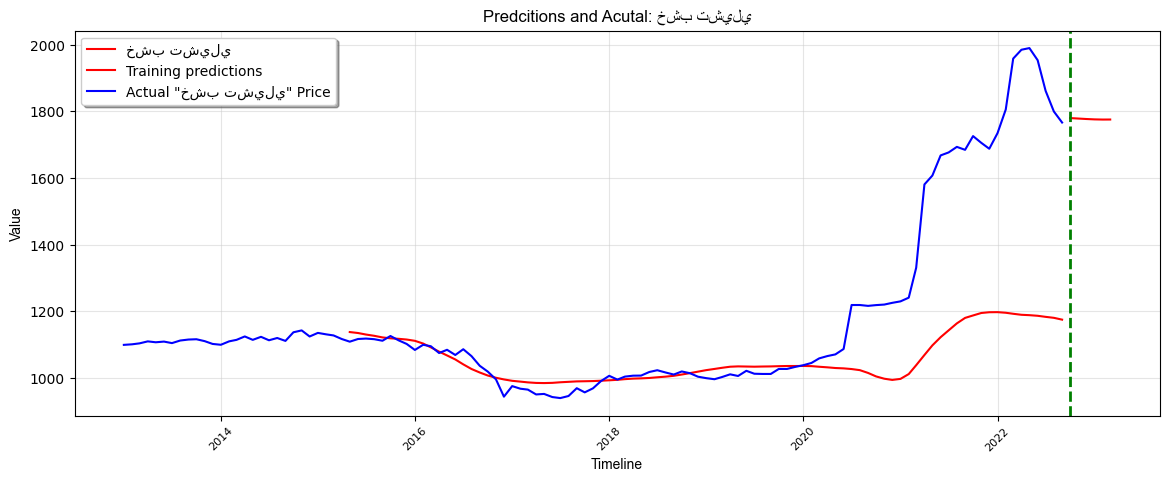

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  3144.831     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  3144.788     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  3144.237     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  3143.983     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  3144.417     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  4614.950     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  4160.730     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3944.770     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3548.280      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3288.540      85.14  11,405.32  1,672.00           2.56   

      historical  
0    2789.032233  
1    3144.831000  
2    3144.788000  
3    3144.237000  
4   

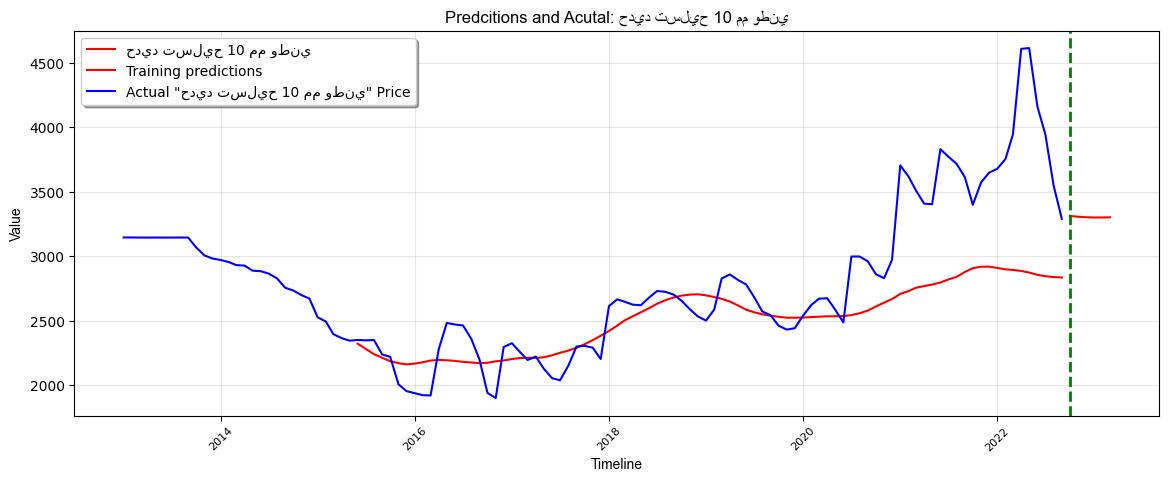

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  44.506     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  44.622     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  44.772     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  44.520     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  43.847     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  61.390     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  61.070     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  60.610     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  59.760      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  58.320      85.14  11,405.32  1,672.00           2.56   

     historical  
0     40.972655  
1     44.506000  
2     44.622000  
3     44.772000  
4     44.520000  
..          ...

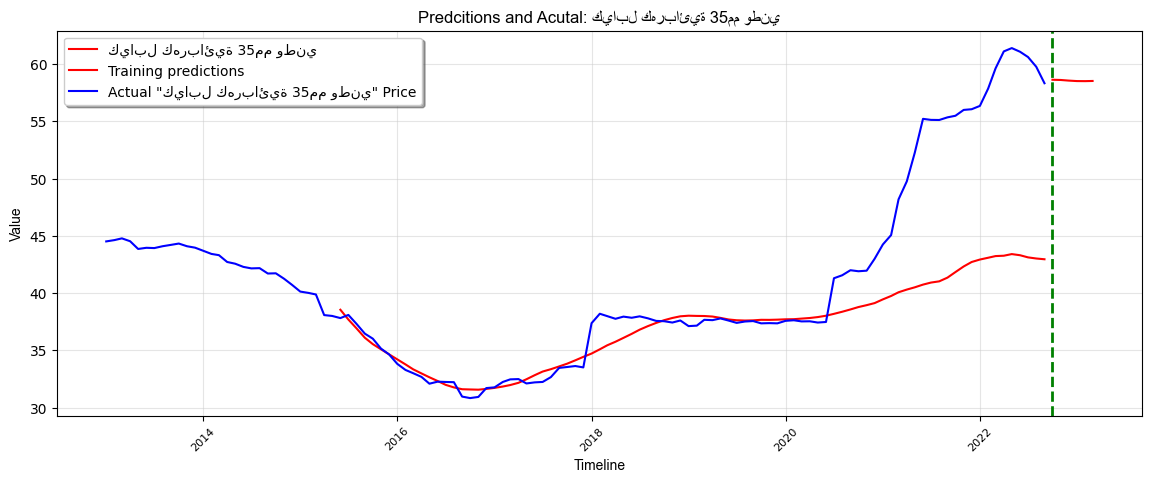

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  66.612     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  66.375     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  66.521     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  66.285     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  66.562     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  94.880     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  92.360     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  89.610     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  90.030      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  90.050      85.14  11,405.32  1,672.00           2.56   

     historical  
0     69.140017  
1     66.612000  
2     66.375000  
3     66.521000  
4     66.285000  
..          ...

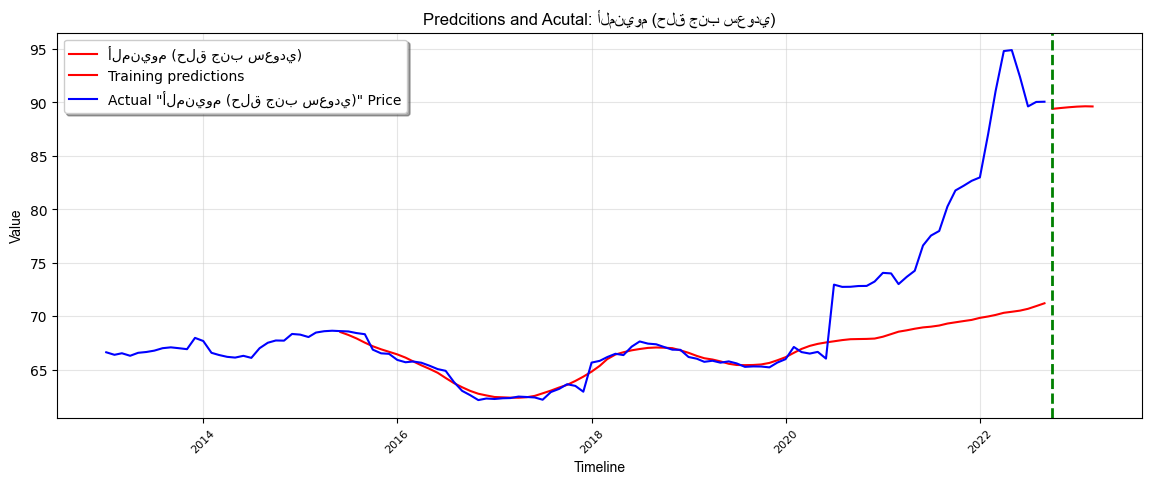

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  3185.208     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  3185.208     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  3184.917     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  3184.833     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  3184.917     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  4543.110     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  4096.760     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3839.310     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3443.460      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3200.180      85.14  11,405.32  1,672.00           2.56   

      historical  
0    2790.110621  
1    3185.208000  
2    3185.208000  
3    3184.917000  
4   

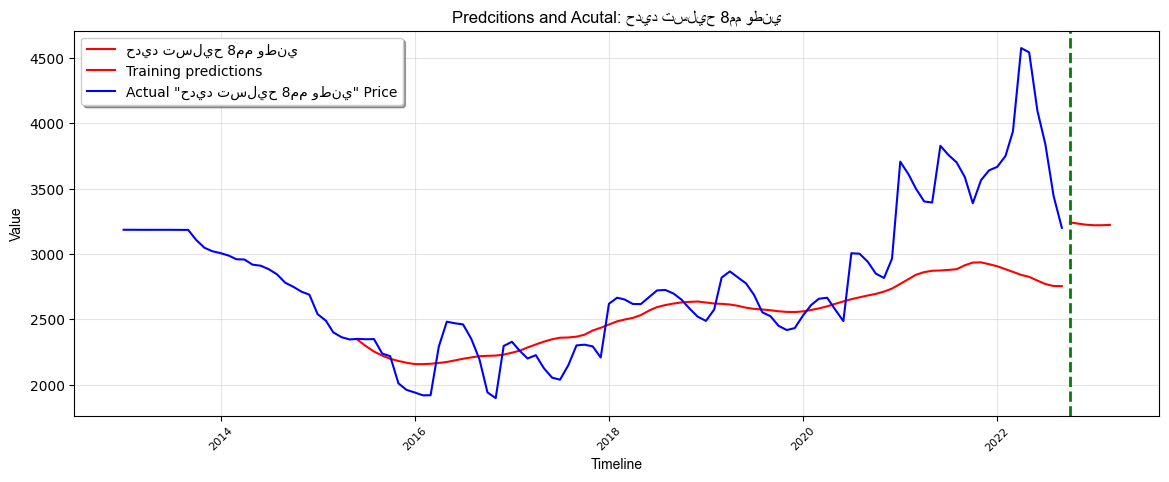

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2964.917     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2964.750     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2964.942     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2964.917     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2964.917     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  4000.960     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  3704.880     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3595.940     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3288.840      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3116.300      85.14  11,405.32  1,672.00           2.56   

     historical  
0    2615.09244  
1    2964.91700  
2    2964.75000  
3    2964.94200  
4    2964

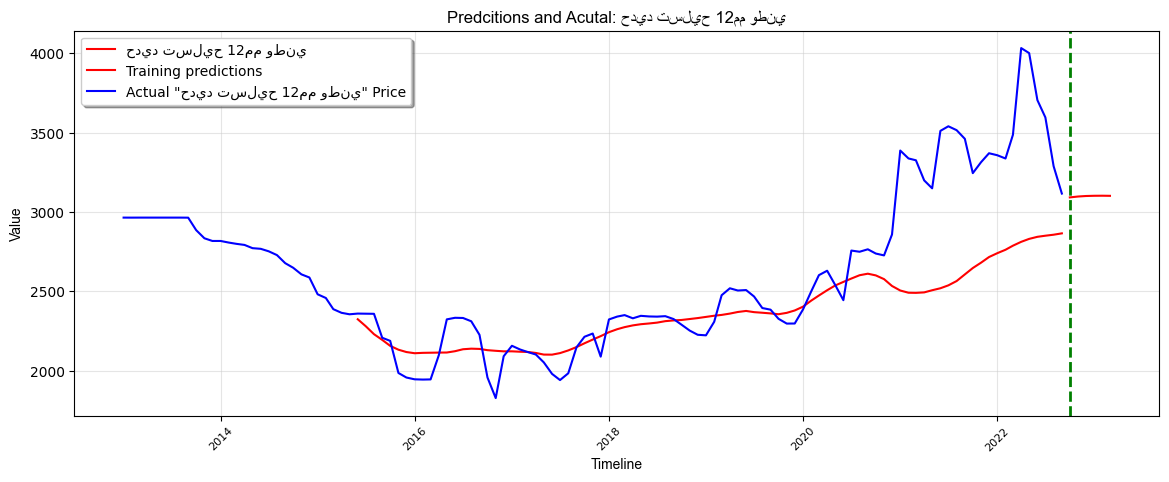

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2934.746     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2934.831     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2934.746     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2934.746     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2934.917     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  3991.510     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  3690.890     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3571.570     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3275.300      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3101.690      85.14  11,405.32  1,672.00           2.56   

      historical  
0    2602.189474  
1    2934.746000  
2    2934.831000  
3    2934.746000  
4   

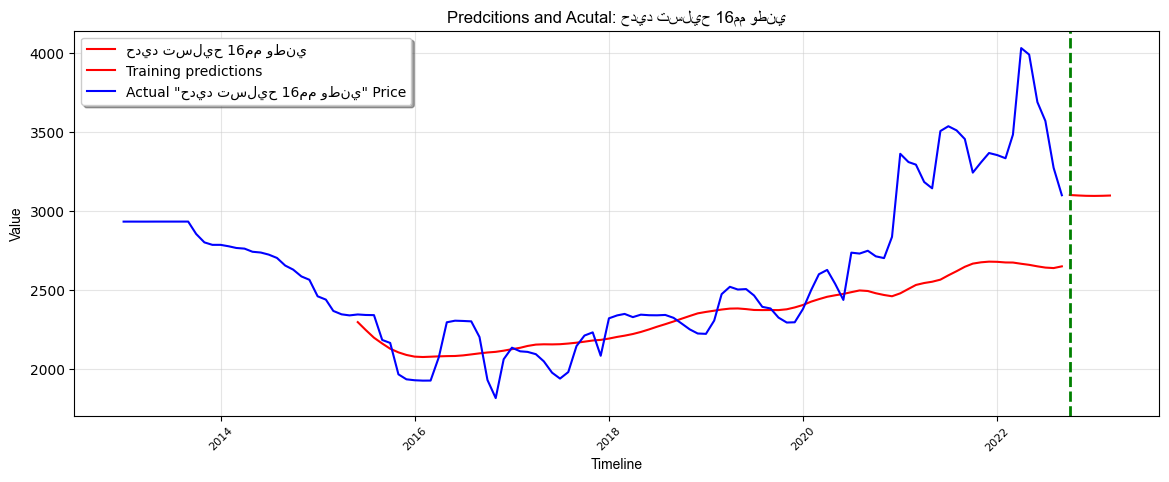

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  15.385     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  15.423     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  15.400     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  15.370     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  15.353     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  21.460     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  21.380     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  21.360     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  21.170      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  20.890      85.14  11,405.32  1,672.00           2.56   

     historical  
0        14.471  
1        15.385  
2        15.423  
3        15.400  
4        15.370  
..          ...

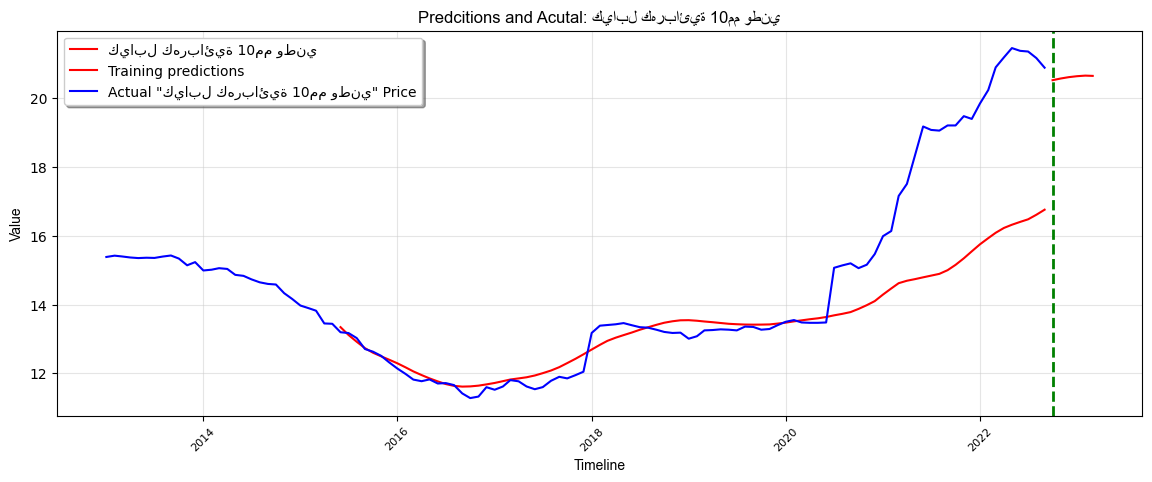

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date    price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  189.656     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  188.713     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  189.738     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  190.233     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  189.617     100.20   7,404.12  1,393.00           0.11   
..         ...      ...        ...        ...       ...            ...   
111 2022-05-01  192.390     115.60  12,921.74  1,848.40           0.77   
112 2022-06-01  192.800     109.03  11,523.25  1,812.00           1.21   
113 2022-07-01  192.480     103.97  12,199.08  1,771.50           1.68   
114 2022-08-01  191.240      95.64  12,283.33  1,721.40           2.33   
115 2022-09-01  191.190      85.14  11,405.32  1,672.00           2.56   

     historical  
0    179.418235  
1    189.656000  
2    188.713000  
3    189.738000  
4    190.233000  
.. 

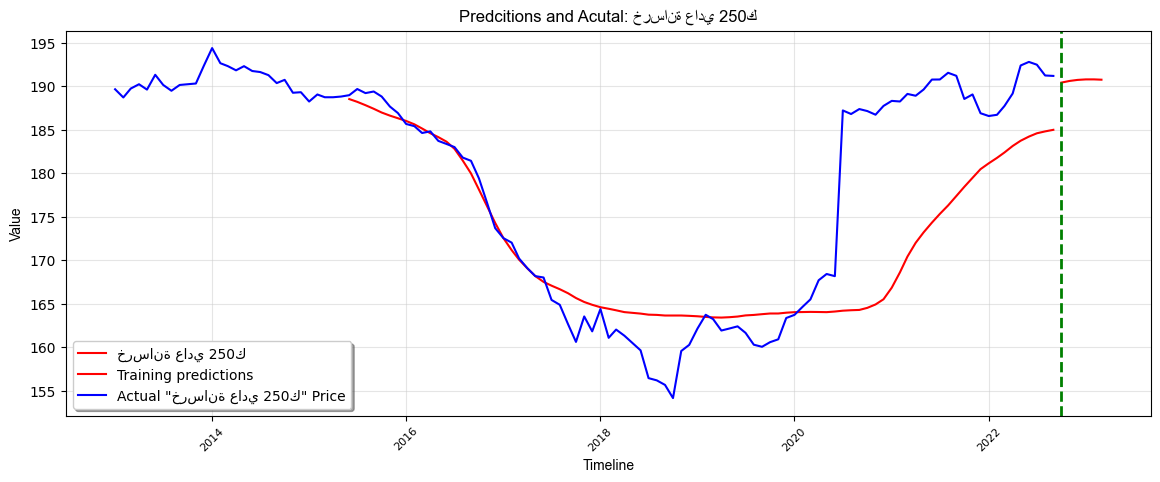

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  51.445     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  51.745     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  51.590     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  50.201     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  50.908     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  44.970     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  45.240     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  45.240     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  45.110      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  45.050      85.14  11,405.32  1,672.00           2.56   

     historical  
0     46.735819  
1     51.445000  
2     51.745000  
3     51.590000  
4     50.201000  
..          ...

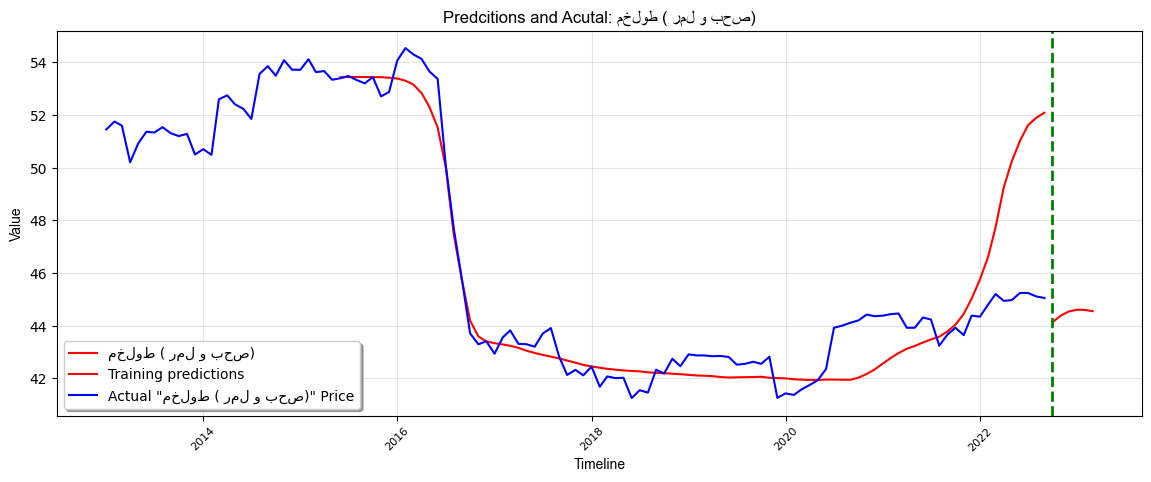

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date   price  oil_brent       tasi      gold  interest_rate  \
82  2013-01-01  11.800     114.54   7,043.55  1,662.00           0.14   
83  2013-02-01  11.746     110.42   6,998.33  1,578.90           0.15   
84  2013-03-01  11.742     109.79   7,125.73  1,595.70           0.14   
85  2013-04-01  11.683     102.04   7,179.80  1,472.70           0.15   
86  2013-05-01  11.796     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
97  2022-05-01  15.310     115.60  12,921.74  1,848.40           0.77   
98  2022-06-01  15.820     109.03  11,523.25  1,812.00           1.21   
99  2022-07-01  15.940     103.97  12,199.08  1,771.50           1.68   
100 2022-08-01  16.240      95.64  12,283.33  1,721.40           2.33   
113 2022-09-01  16.070      85.14  11,405.32  1,672.00           2.56   

     historical  
82       11.798  
83       11.800  
84       11.746  
85       11.742  
86       11.683  
..          ...

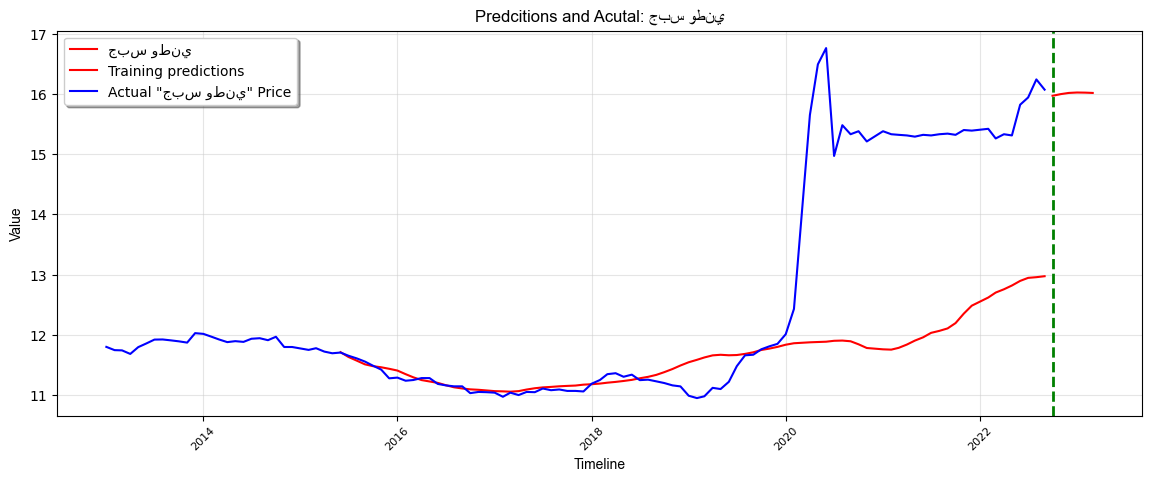

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  3859.083     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  3859.083     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  3859.083     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  3862.400     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  3862.417     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  4813.380     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  4524.720     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  4501.420     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  4394.300      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  4242.260      85.14  11,405.32  1,672.00           2.56   

      historical  
0    3541.228819  
1    3859.083000  
2    3859.083000  
3    3859.083000  
4   

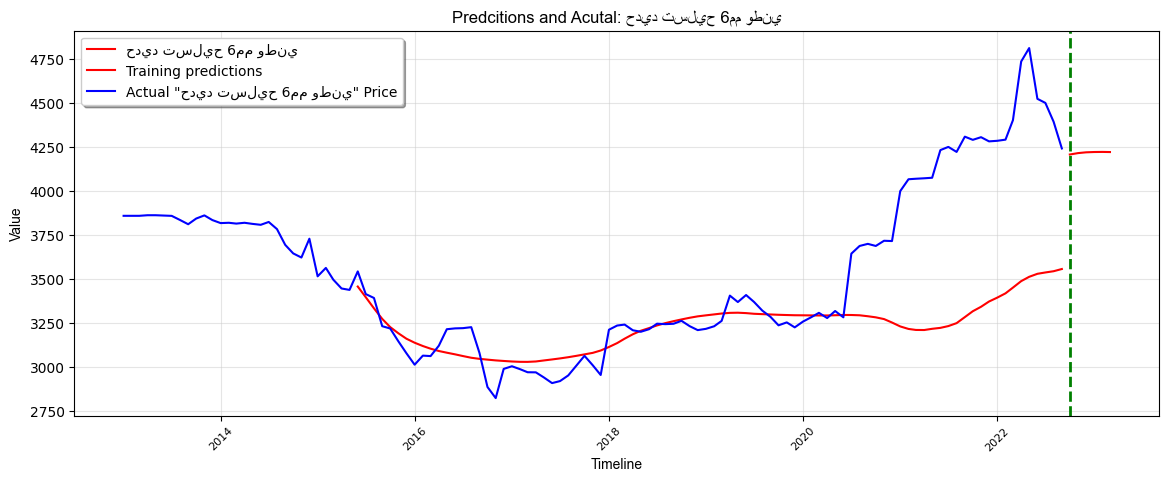

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\2121924846.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


In [127]:
for e in elements['element_name']:
    pipeline(e+'.xlsx')
